In [14]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from tqdm import tqdm, tqdm_notebook

import json

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
input_path = './data/'
joke_frame = pd.read_csv(input_path + 'JokeText.csv')
jokes = joke_frame.JokeText

In [16]:
jokes

0     A man visits the doctor. The doctor says "I ha...
1     This couple had an excellent relationship goin...
2     Q. What's 200 feet long and has 4 teeth? \n\nA...
3     Q. What's the difference between a man and a t...
4     Q.\tWhat's O. J. Simpson's Internet address? \...
                            ...                        
95    Two attorneys went into a diner and ordered tw...
96    A teacher is explaining to her class how diffe...
97    Age and Womanhood\n\n1. Between the ages of 13...
98    A bus station is where a bus stops.\nA train s...
99    Q: Whats the difference between greeting a Que...
Name: JokeText, Length: 100, dtype: object

In [17]:
# Creating a list of stopwords
stops = stopwords.words('english')
# Add stop variants without single quotes
no_quotes = [re.sub(r'\'','',word) for word in stops if "'" in word]
stops.extend(no_quotes)

In [22]:
def clean_string(string):
    # remove non-letters
    temp = re.sub("[^a-zA-Z]"," ", string)
    # remove anything that is less than two characters
    temp = re.sub(r'\b\w{1,2}\b','',temp)
    # remove multiple spaces
    temp = re.sub(r'\s\s+', ' ', temp)
    return temp

def str_preprocess(string):
    stemmer = PorterStemmer()
    # removing punctuation
    removed_punc = ''.join([char for char in string if char not in punctuation])
    # removing stopwords
    cleaned = [stemmer.stem(word.lower()) for word in removed_punc.split(' ') if word not in stops]
    return ' '.join(cleaned)

In [23]:
cleaned_frame = jokes.apply(clean_string).apply(str_preprocess)

In [24]:
cleaned_frame

0      man visit doctor the doctor say bad news you ...
1     thi coupl excel relationship go one day came h...
2      what feet long teeth the front row willi nels...
3      what differ man toilet toilet follow around use 
4      what simpson internet address slash slash bac...
                            ...                        
95    two attorney went diner order two drink then p...
96     teacher explain class differ languag use neg ...
97    age womanhood between age she like africa virg...
98     bu station bu stop train station train stop d...
99     what differ greet queen greet presid unit sta...
Name: JokeText, Length: 100, dtype: object

In [26]:
td_idf_vec = TfidfVectorizer(stop_words=stops, max_features = 20000)
X = td_idf_vec.fit_transform(cleaned_frame)
X_norm = normalize(X)
X_arr = X_norm.toarray()

In [27]:
data_svd = TruncatedSVD(n_components = 10) #BEST VALUE FOR TIME-COMPLEXITY IS N=250
response_svd = data_svd.fit_transform(X_arr)

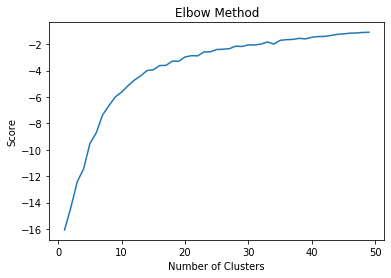

In [28]:
# TESTING FOR THE OPTIMAL NUMBER OF K CLUSTERS FOR THE KMEANS MODEL
number_clusters = range(1, 50) # BEST ONE WAS 4-7
max_iter_number = range(1, 1000, 100) # BEST ONE WAS 100
kmeans = [MiniBatchKMeans(n_clusters=i, batch_size = 50, init= 'k-means++', max_iter = 100) for i in number_clusters]
score = [kmeans[i].fit(response_svd).score(response_svd) for i in tqdm_notebook(range(len(kmeans)))]
# PLOTTING ELBOW PLOT
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [38]:
k_value = 20
kmeans = MiniBatchKMeans(n_clusters=k_value, batch_size = 100, init= 'k-means++', max_iter = 100)
fitted_values = kmeans.fit(response_svd)
predicted_values = kmeans.predict(response_svd)

In [39]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = td_idf_vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(X_arr, predicted_values, 15)

In [40]:
print(dfs)

[    features     score
0       bulb  0.422558
1      light  0.355599
2      screw  0.329802
3       mani  0.237342
4       take  0.214461
5        men  0.150766
6   feminist  0.119255
7      funni  0.102461
8    stalker  0.082276
9     replac  0.075498
10     watch  0.075498
11     night  0.075498
12   definit  0.073835
13       one  0.072150
14     anyth  0.071405,     features     score
0       blah  0.080908
1     dyslex  0.080204
2      slash  0.073014
3      phone  0.067451
4       hear  0.058601
5    station  0.050271
6    chukcha  0.044958
7   parakeet  0.037564
8      shred  0.037564
9      tweet  0.037564
10   lawnmow  0.037564
11      stop  0.036522
12        bu  0.036522
13     train  0.036522
14      juan  0.032693,       features     score
0          say  0.117187
1       darwin  0.080484
2          bob  0.068448
3         make  0.059343
4          one  0.054937
5   swartzeneg  0.047500
6      stallon  0.047500
7     buddhist  0.043897
8       vendor  0.043897
9          

In [41]:
predicted_values

array([ 8, 19, 11,  5,  1, 13,  0,  1, 11, 12, 11,  2, 19,  9, 12, 11,  0,
       11, 12,  5,  5, 11, 15,  1, 17, 18,  2,  3,  2,  5, 19, 14, 14, 15,
        1, 10,  6, 18,  7,  4,  2, 14,  2, 10,  6,  9,  3, 19,  3,  9,  1,
        2,  9, 19,  1,  2,  1,  4,  1,  2, 11, 16, 15,  1, 17, 19,  9, 14,
        9, 17, 15,  1,  5,  0,  5,  7, 11,  5,  9, 13, 14,  2,  1,  3,  0,
       10,  8, 14,  2,  4, 11,  6, 16, 12, 11, 15, 12, 11,  1,  5],
      dtype=int32)

In [49]:
df = pd.DataFrame(predicted_values, columns = ['cluster'])

In [50]:
df

,cluster
0,8
1,19
2,11
3,5
4,1
...,...
95,15
96,12
97,11
98,1


In [67]:
clusters = [df[df.cluster == i].index.values for i in range(k_value)]

In [76]:
for i in range(len(clusters)):
    for item in jokes[clusters[i]]:
        print('Cluster {0}:\n{1}'.format(i,item))

Cluster 0:
How many feminists does it take to screw in a light bulb?
That's not funny.

Cluster 0:
How many men does it take to screw in a light bulb? 

One...men will screw anything. 

Cluster 0:
Q: How many stalkers does it take to change a light bulb?

A: Two. One to replace the bulb, and the other to watch it day and night.

Cluster 0:
Q: How many Presidents does it take to screw in a light bulb?

A: It depends upon your definition of screwing a light bulb.

Cluster 1:
Q.	What's O. J. Simpson's Internet address? 
A.	Slash, slash, backslash, slash, slash, escape.

Cluster 1:
Q. Did you hear about the dyslexic devil worshiper? 

A. He sold his soul to Santa.

Cluster 1:
What do you get when you run over a parakeet with a lawnmower? 
Shredded tweet.

Cluster 1:
An explorer in the deepest Amazon suddenly finds himself surrounded
by a bloodthirsty group of natives. Upon surveying the situation, he
says quietly to himself, "Oh God, I'm screwed." 

The sky darkens and a voice booms out, "